# **COHORT ANALYSIS**



A cohort represents a group of a population or an area of study which shares something in common within a specified period. For example, a group of people born in Uganda in 2000 is an example of a cohort related to the number of births in a country. Likewise, in terms of business problems, cohorts represent a group of customers or users. For example:

*   Several users who purchased the subscription the app in a given period.
*   The number of users who cancelled a subscription during the same month.

Cohorts analysis make it easy to analyze the user behaviour and trends without having to look at the behaviour of each user individually.

**Why Cohort Analysis?**

The Cohort analysis is important for the growth of a business because of the specificity of the information it provides. The most valuable feature of cohort analysis is that it helps companies answer some of the targeted questions by examining the relevant data. Some of the advantages of cohort analysis in a business are:



*   It helps to understand how the behaviour of users can affect the business  
    in terms of acquisition and retention.
*   It helps to analyze the customer churn rate.
*   It also helps in calculating the lifetime value of a customer.
*   It helps in finding the points where we need to increase more engagement 
    with the customer.


**Types of Cohorts**


1.   Time Cohort
2.   Behaviour Cohort
3.   Size Cohort

Time cohorts are customers who have signed up for a product or service during a specified period. Analysis of these cohorts shows the behaviour of customers based on when they started using the company’s products or services. The time can be monthly or quarterly or even daily.

Behaviour cohorts are customers who have purchased a product or subscribed to service in the past. It groups customers according to the type of product or service to which they have subscribed. Customers who signed up for basic services may have different needs than those who signed up for advanced services. Understanding the needs of different cohorts can help a business design tailor-made services or products for particular segments.

Size cohorts refer to the different sizes of customers who purchase the company’s products or services. This categorization can be based on the amount of spend in a certain period after acquisition or the type of product that the customer has spent most of the amount of their order in a given period.

# **ANALYSIS**

I will start this task by importing the necessary Python libraries and the dataset: https://www.kaggle.com/jihyeseo/online-retail-data-set-from-uci-ml-repo/download

In [2]:
# import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For Machine Learning Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Checking for missing data: 

In [3]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

So there is some missing data in the Description and Customer ID columns.



In [4]:
df= df.dropna(subset=['CustomerID'])

Now let’s check and clean the duplicate data:

In [5]:
df.duplicated().sum()

5225

In [6]:
df = df.drop_duplicates()
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


Note that the minimum for the unit price = 0 and the minimum for the quantity is with a negative value.

In [7]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]

We’ve done all of the data cleansings now running a cohort analysis with Python. For the cohort analysis there are a few labels we need to create:

1. Billing period: String representation of the year and month of a single transaction/invoice.
2. Cohort Group: A string representation of the year and month of a customer’s first purchase. This label is common to all invoices for a particular customer.
3. Cohort Period / Cohort Index: Full representation of a client’s stage in their “lifespan”. The number represents the number of months since the first purchase.

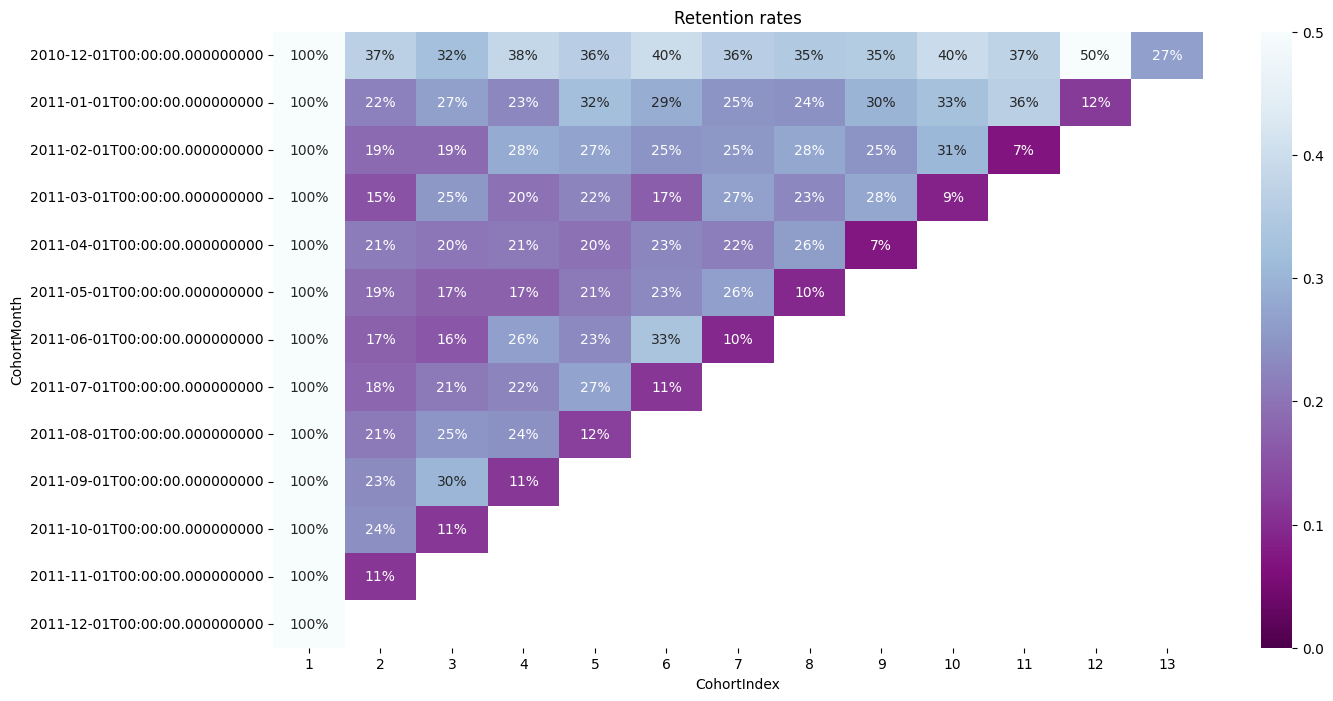

In [8]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')

def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df['CohortIndex'] = year_diff * 12 + month_diff + 1 

#Count monthly active customers from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')

# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()

Customer retention is a very useful metric to understand how many of all customers are still active. Loyalty gives you the percentage of active customers compared to the total number of customers.

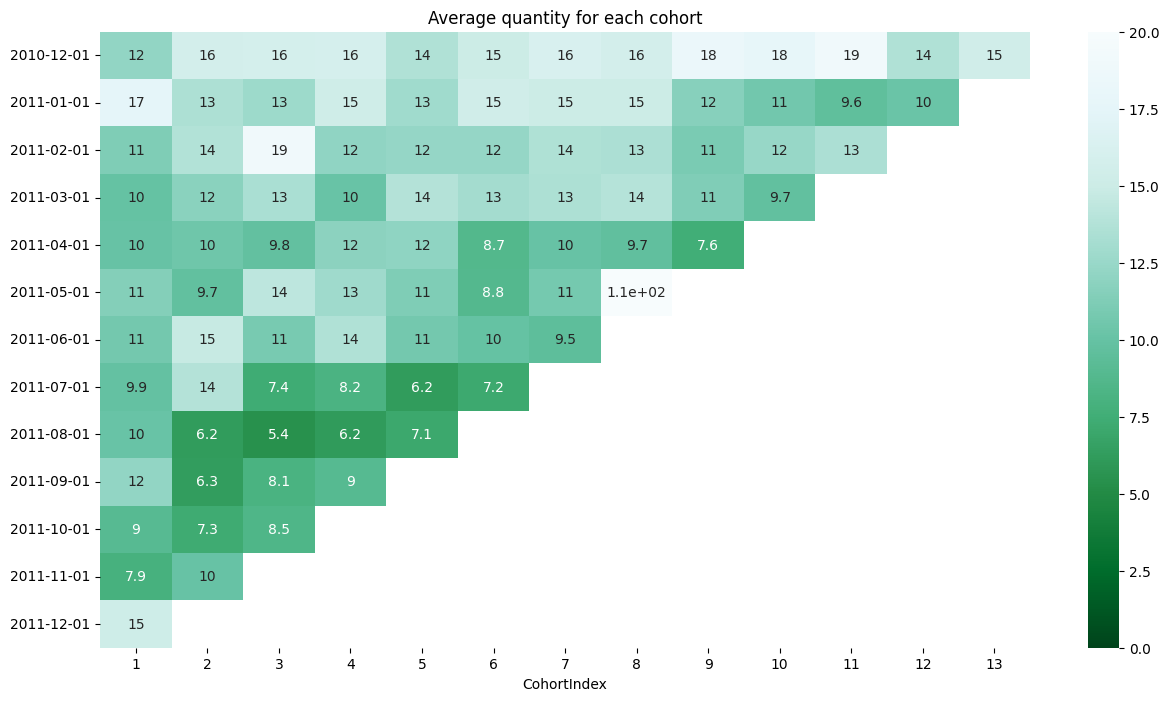

In [9]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()